# Módulo 4: Implementación de autocodificadores con Pytorch

## Introducción

En este cuaderno, seguiremos construyendo a partir de los fundamentos de PyTorch que aprendimos en el módulo 3, e implementaremos un tipo diferente de arquitectura de red neuronal: un autocodificador.

El objetivo principal de los autocodificadores es aprender una representación simplificada o codificada de un conjunto de datos. En primer lugar, dividimos la red en dos: en un codificador y un decodificador. El codificador empieza por el *input* y lo reduce a una representación latente más sencilla. El decodificador, por otro lado, toma esa representación y reproduce el *input* original.

En el siguiente cuaderno, exploraremos dos autocodificadores diferentes. Entrenaremos el primero con 3 cifras de MNIST, y después visualizaremos la representación latente en 2D.

El segundo es una red más grande que entrenaremos con todo el conjunto MNIST para reconstruir, después, las imágenes de *input* a partir del *output*.

## Codificador simple con las cifras 0, 1, 2 de MNIST

Para nuestra primera red de autocodificador, vamos a recrear el ejemplo del módulo 4, con las cifras 0, 1 y 2 del conjunto de datos MNIST.

Primero, entrenaremos el autocodificador usando la raíz del ECM con *inputs* y etiquetas idénticos. Cuando el autocodificador esté entrenado, visualizaremos la codificación del espacio latente en 2D.



### Preparación del conjunto de datos e importación del módulo

Aquí, cargaremos el conjunto de datos MNIST que usamos en la actividad evaluable del módulo 3. Es muy fácil de usar porque está integrado en PyTorch.

Además, reduciremos el conjunto de datos para que solo contenga las cifras 0, 1 y 2.

In [16]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.datasets
from torchvision import transforms
from torch.utils.data import Subset
from torch.utils.data import DataLoader
import time, copy
# Configuración del dispositivo (si es posible, entrenar el modelo en la GPU, el proceso será mucho más rápido)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [17]:
# Estas transformaciones sucederán en todos los puntos de datos. En este ejemplo,
# queremos convertir cada punto de datos en un tensor y realizar una normalización

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)
# Nos quedaremos solamente con las cifras 0, 1 y 2
train_indices = [idx for idx, target in enumerate(mnist_train.targets) if target in [0, 1, 2]]
mnist_train = Subset(mnist_train, train_indices)

# Dividiremos el conjunto de datos de entrenamiento en entrenamiento y validación
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [int(np.floor(len(mnist_train)*0.75)), int(np.ceil(len(mnist_train)*0.25))])

# Para la prueba, también nos quedaremos solo con las cifras 0, 1 y 2
mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)
test_indices = [idx for idx, target in enumerate(mnist_test.targets) if target in [0, 1, 2]]
mnist_test = Subset(mnist_test, test_indices)


In [18]:
# Crearemos DataLoaders igual que antes, con un tamaño de lotes de 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 13967, 'val': 4656, 'test': 3147}


### Definición e hiperparámetros del modelo

Esta red se parece mucho a las que construimos en el módulo 3, con capas lineales y activación ReLU. Sin embargo, aquí la hemos dividido en dos secciones diferentes: codificador y decodificador. Escribir el código de esta manera nos permite codificar fácilmente un punto de datos específico después de entrenar al modelo.

In [23]:
class SimpleAutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(SimpleAutoEncoder, self).__init__()
        # Dividir el codificador y el decodificador
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_size)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def encode(self, x):
        return self.encoder(x)



In [24]:
# Hiperparámetros

input_size = 784 # Alisar el conjunto de datos 28 * 28 = 784
learning_rate = 0.001
num_epochs = 5

In [25]:
model = SimpleAutoEncoder(input_size).to(device)
print(model)

SimpleAutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
  )
)


### Entrenar al modelo

Esta función de entrenamiento es muy similar a las de las secciones anteriores. La clave es entender que la función de un autocodificador es muy similar a la regresión, de manera que no tenemos etiquetas específicas de clase o precisión, solo de pérdida.

In [7]:
# Extraído de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Los mejores pesos se deben guardar por separado
    best_loss = np.inf
    best_epoch = 0

    # Cada ciclo tiene una fase de entrenamiento, una de validación y una de prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en el modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en el modo de evaluación

            running_loss = 0.0

            # Iterar con los datos - para el autocodificador no nos importan las etiquetas,
            # estamos entrenando al input contra sí mismo
            for inputs, _ in dataloaders[phase]:
                # Importante: se deben aplanar todos los puntos de datos
                # para que sean compatibles con el modelo
                # print(inputs.shape)
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                # Los objetivos son iguales que los inputs
                targets = inputs.to(device)
                # print(inputs.shape)
                # print(targets.shape)

                # Poner a 0 los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # print(outputs.shape)
                    loss = criterion(outputs, targets)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # Hacer una copia profunda del modelo si se ha alcanzado la mejor precisión
            if phase == 'val' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves



In [8]:
# Pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

model, training_curves = train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/5
----------
train Loss: 0.2729
val   Loss: 0.1928
test  Loss: 0.1929

Epoch 2/5
----------
train Loss: 0.1815
val   Loss: 0.1693
test  Loss: 0.1703

Epoch 3/5
----------
train Loss: 0.1656
val   Loss: 0.1604
test  Loss: 0.1614

Epoch 4/5
----------
train Loss: 0.1583
val   Loss: 0.1544
test  Loss: 0.1555

Epoch 5/5
----------
train Loss: 0.1521
val   Loss: 0.1477
test  Loss: 0.1486

Training complete in 0m 33s
Best val Loss: 0.147711 at epoch 4


### Visualizar la codificación del espacio latente

Ahora que el autocodificador está entrenado, vamos a visualizar la codificación del espacio latente en 2D para las distintas cifras.

In [26]:
import matplotlib.pyplot as plt

x = []
label = []
# Subconjunto aleatorio de prueba, tomar x e y
# Trazar en matplotlib
for inputs, labels in dataloaders["test"]:
    inputs = inputs.view(inputs.shape[0],-1)
    inputs = inputs.to(device)
    for i, input in enumerate(inputs):
        encoding = model.encode(input)
        x.append(encoding.cpu().detach().numpy())
        label.append(labels[i])

def plot_dataset(x,y):
    print(len(x))
    print(len(y))
    x_np = np.array(x)
    x_np.reshape(len(x), 2)
    colors = []
    for label in y:
        if label == 0:
            colors.append("red")
        elif label == 1:
            colors.append("blue")
        else:
            colors.append("green")
    plt.scatter(x_np[...,0], x_np[...,1], color=colors)


3147
3147


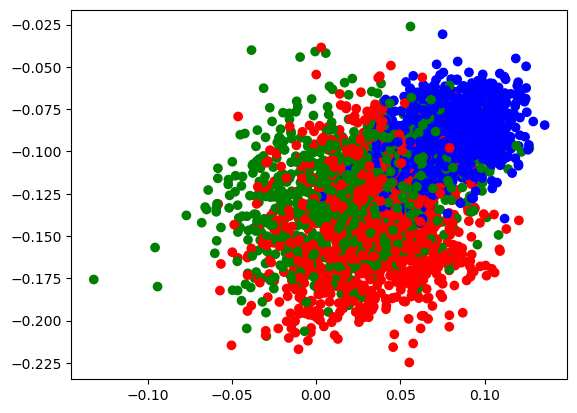

In [27]:
plot_dataset(x,label)

Aquí, vemos que el codificador ha separado de forma muy eficaz las distintas clases de cifras. En la imagen, hay 3 clústeres distintos para cada una de las cifras: 0, 1 y 2.

## Autocodificador con todo el conjunto MNIST

Ahora que hemos visto lo que puede hacer un autocodificador en el espacio latente, vamos a construir una red más profunda para expandirla a todo el conjunto MNIST.

El proceso de entrenamiento será el mismo que antes, solo que la red contendrá más capas y un espacio latente de más dimensiones para reproducir de forma más precisa el *input*.

### Preparación del conjunto de datos

In [28]:
# Estas transformaciones sucederán en todos los puntos de datos. En este ejemplo,
# queremos convertir cada punto de datos en un tensor y realizar una normalización

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])
mnist_train = torchvision.datasets.MNIST('', train=True, transform =transform, download=True)

# Dividiremos el conjunto de datos de entrenamiento en entrenamiento y validación
mnist_train, mnist_val = torch.utils.data.random_split(mnist_train, [int(np.floor(len(mnist_train)*0.75)), int(np.ceil(len(mnist_train)*0.25))])

mnist_test = torchvision.datasets.MNIST('', train=False, transform = transform, download=True)

In [29]:
# Crearemos DataLoaders igual que antes, con un tamaño de lotes de 100
batch_size = 100
dataloaders = {'train': DataLoader(mnist_train, batch_size=batch_size),
               'val': DataLoader(mnist_val, batch_size=batch_size),
               'test': DataLoader(mnist_test, shuffle=True, batch_size=batch_size)}

dataset_sizes = {'train': len(mnist_train),
                 'val': len(mnist_val),
                 'test': len(mnist_test)}
print(f'dataset_sizes = {dataset_sizes}')

dataset_sizes = {'train': 45000, 'val': 15000, 'test': 10000}


### Definición e hiperparámetros del modelo

Aquí utilizamos un espacio latente de 32 dimensiones. Esto permite codificar mucha más información y, por tanto, una codificación más precisa.

In [37]:
class AutoEncoder(nn.Module):
    def __init__(self, input_size):
        super(AutoEncoder, self).__init__()
        # Dividir el codificador y el decodificador
        self.encoder = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256,32)
        )

        self.decoder = nn.Sequential(
            nn.Linear(32, 256),
            nn.ReLU(),
            nn.Linear(256, input_size)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def encode(self, x):
        return self.encoder(x)



In [31]:
# Hiperparámetros

input_size = 784 # Alisar el conjunto de datos 28 * 28 = 784
learning_rate = 0.001
num_epochs = 10

In [32]:
model = AutoEncoder(input_size).to(device)
print(model)

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
  )
)


### Entrenar al modelo

Vamos a utilizar la misma función que arriba porque seguimos entrenando un autocodificador. La hemos copiado debajo para mayor comodidad.

In [33]:
# Extraído de https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

def train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) # Los mejores pesos se deben guardar por separado
    best_loss = np.inf
    best_epoch = 0

    # Cada ciclo tiene una fase de entrenamiento, una de validación y una de prueba
    phases = ['train', 'val', 'test']
    
    # Hacer un seguimiento de la evolución de la pérdida y la precisión durante el entrenamiento
    training_curves = {}
    for phase in phases:
        training_curves[phase+'_loss'] = []
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()  # Configurar el modelo en el modo de entrenamiento
            else:
                model.eval()   # Configurar el modelo en el modo de evaluación

            running_loss = 0.0

            # Iterar con los datos - para el autocodificador no nos importan las etiquetas,
            # estamos entrenando al input contra sí mismo
            for inputs, _ in dataloaders[phase]:
                # Importante: se deben aplanar todos los puntos de datos
                # para que sean compatibles con el modelo
                inputs = inputs.view(inputs.shape[0],-1)
                inputs = inputs.to(device)
                # Los objetivos son los mismos que los inputs
                targets = inputs.to(device)

                # Poner a 0 los gradientes de los parámetros
                optimizer.zero_grad()

                # Método forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)

                    # Método backward y actualización de los pesos solo si está en la fase de entrenamiento
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Estadísticas
                running_loss += loss.item() * inputs.size(0)
 
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            training_curves[phase+'_loss'].append(epoch_loss)

            print(f'{phase:5} Loss: {epoch_loss:.4f}')

            # Hacer una copia profunda del modelo si se ha alcanzado la mejor precisión
            if phase == 'val' and epoch_loss < best_loss:
              best_epoch = epoch
              best_loss = epoch_loss
              best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Loss: {best_loss:4f} at epoch {best_epoch}')

    # Cargar los mejores pesos del modelo
    model.load_state_dict(best_model_wts)
    
    return model, training_curves



In [34]:
# Pérdida y optimizador
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

model, training_curves = train_autoencoder(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, num_epochs=num_epochs)


Epoch 1/10
----------
train Loss: 0.1230
val   Loss: 0.0727
test  Loss: 0.0714

Epoch 2/10
----------
train Loss: 0.0687
val   Loss: 0.0659
test  Loss: 0.0645

Epoch 3/10
----------
train Loss: 0.0634
val   Loss: 0.0611
test  Loss: 0.0598

Epoch 4/10
----------
train Loss: 0.0595
val   Loss: 0.0582
test  Loss: 0.0569

Epoch 5/10
----------
train Loss: 0.0568
val   Loss: 0.0556
test  Loss: 0.0544

Epoch 6/10
----------
train Loss: 0.0546
val   Loss: 0.0540
test  Loss: 0.0528

Epoch 7/10
----------
train Loss: 0.0529
val   Loss: 0.0526
test  Loss: 0.0516

Epoch 8/10
----------
train Loss: 0.0515
val   Loss: 0.0510
test  Loss: 0.0500

Epoch 9/10
----------
train Loss: 0.0503
val   Loss: 0.0498
test  Loss: 0.0488

Epoch 10/10
----------
train Loss: 0.0492
val   Loss: 0.0488
test  Loss: 0.0479

Training complete in 3m 7s
Best val Loss: 0.048822 at epoch 9


### Visualizar los resultados

Ahora que el modelo está entrenado, vamos a visualizar los resultados del autocodificador.

Más abajo, hemos incluido una función que muestra el *input* y la autocodificación de una cifra específica. Pruebe a ejecutarlo con diferentes cifras y observe cuáles se parecen más.

In [35]:
import matplotlib.pyplot as plt

# Trazar una ground truth sobre las cifras y autocodificar
def plot_digit(digit, count = 1):
    fig = plt.figure()
    idx = 1
    for inputs, labels in dataloaders["test"]:
        # Alisar el conjunto de datos para que las dimensiones se alineen con el modelo
        inputs = inputs.view(inputs.shape[0],-1)
        inputs = inputs.to(device)
        for i, input in enumerate(inputs):
            # Solo queremos mostrar determinadas cifras
            if (labels[i] != digit):
                continue
            # Ejecutar el autocodificador
            autoencoding = model.forward(input)
            # Volver a la cpu()
            autoencoding = autoencoding.cpu().detach().numpy()
            # Remodelar en forma de imagen
            autoencoding = autoencoding.reshape((28,28))
            input = input.cpu().detach().numpy().reshape((28,28))
            # Trazar la ground truth
            ax = fig.add_subplot(2, count, idx)
            ax.imshow(input, cmap='gray')
            # Trazar la autocodificación
            ax = fig.add_subplot(2, count, idx+count)
            ax.imshow(autoencoding, cmap='gray')
            idx += 1
            if idx > count:
                break
        if idx > count:
            break

In [77]:
# Trazar una ground truth sobre las cifras y autocodificar
def plot_a_digit(digit, id = 0):
    fig, ax = plt.subplots(figsize=(9,9))
    idx = 0
    for inputs, labels in dataloaders["test"]:
        # Alisar el conjunto de datos para que las dimensiones se alineen con el modelo
        inputs = inputs.reshape(inputs.shape[0],-1)
        inputs = inputs.to(device)

        for i, input in enumerate(inputs):
            # Solo queremos mostrar determinadas cifras
            if (labels[i] != digit):
                continue

            input = input.cpu().detach().numpy().reshape((28,28))

            ax.imshow(input, cmap='inferno')

            if idx >= id:
                break
            idx += 1
        if idx >= id:
            break

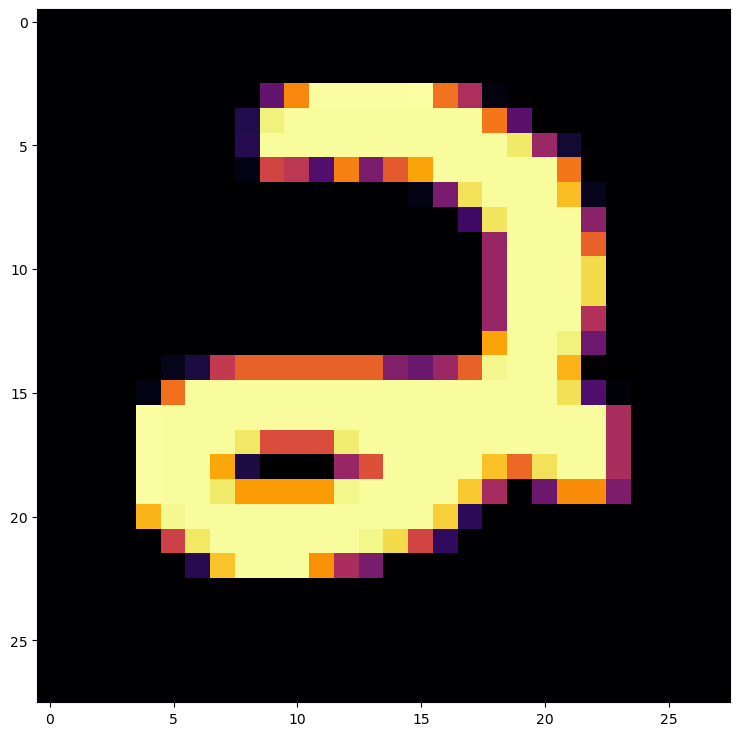

In [328]:
plot_a_digit(2)

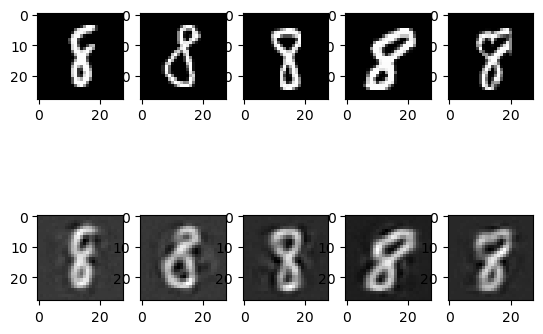

In [40]:
plot_digit(8, 5)

Observando el *output* del autocodificador, vemos que un espacio latente de 32 dimensiones resulta muy eficaz, ya que almacena la información suficiente para hacer una buena reconstrucción.

## ¿Qué viene después?

Hasta ahora, hemos tomado las imágenes de MNIST y las hemos alisado en forma de *arrays* de 1D. Aunque podemos obtener buenos resultados de todos modos, perdemos muchos atributos espaciales que sí están disponibles en 2D. Para poder utilizar estos atributos, introduciremos un nuevo tipo de capa en las redes neuronales: las capas convolucionales.